# <center> Component Four David Webb 20104099 <center>

In [1]:
# import of necessary libraries for the data manipulation

import numpy as np
import pandas as pd
from sklearn import dummy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("notebook")

print('libraries imported')

libraries imported


In [2]:
# load master dataset
df = pd.read_csv('df.csv')

print('data imported')

data imported


### 1. Simplify the ratings variable

In [3]:
# merge not good ratings into one output
ng = ['Inadequate', 'Requires Improvement']

for x in ng:
    df.loc[df['Rating'].str.contains(x), 'Rating'] = 'Not Good'

# drop unknown rating data from the dataset
df = df[df['Rating'] != 'Unknown']

### 2. Establish baseline for a model

In [4]:
# check frequencies of the target variable possibilities
df['Rating'].value_counts()

Good           1625
Not Good        612
Outstanding     506
Name: Rating, dtype: int64

In [5]:
# establish baseline accuracy

# set up dummy classifier model
# classifier is chosen due to non-numeric target variable
cls = dummy.DummyClassifier(strategy = 'most_frequent')
X = df.drop('Rating', axis=1)
y = df['Rating']
cls.fit(X, y)
y_pred = cls.predict(X)

# report dummy classifier accuracy
baseline = round(metrics.accuracy_score(y, y_pred), 3)
print("Baseline accuracy for the 'Rating' target variable: " + str(round(baseline * 100, 1)) + '%')

Baseline accuracy for the 'Rating' target variable: 59.2%


Baseline accuracy has been calculated using a most frequent strategy, where the model has simply predicted that target is always the most frequent value from the raw data.  This strategy was chosen as upon assessing the raw data the 'good' outcome is ~3x more likely to be chosen than either of the other two potential outcomes, rather than an approximately even split.

### 3. Run models with no feature engineering

In [6]:
# set features to float only values to avoid errors in classifiers
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating'], axis=1)
y = df['Rating']

In [7]:
# run k-NN model on data using default setting (k=5, uniform weighting and euclidean distance)
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier()
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
knn = round(scores.mean(),3)
knn

0.191

In [8]:
# run GaussianNB model on data
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
gausNB = round(scores.mean(),3)
gausNB

0.573

In [9]:
# run BernoulliNB model on data
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
bernNB = round(scores.mean(),3)
bernNB

0.579

In [10]:
# run multiclass logistic regression model on the data
# a 'onevrest' strategy is chosen for the multiclass method
from sklearn import linear_model
from sklearn import multiclass
logreg = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000))
scores = cross_val_score(logreg, X, y, cv=5, scoring = 'accuracy')
log_reg = round(scores.mean(),3)
log_reg

# logistic regression classifier set to the default 'lbfgs' solver with a maximum number of 1000 iterations.
# this is to stop warning errors for setting the default solver type and non-convergence timeouts

0.627

In [11]:
# removal of varaibles with negative data to allow MultinomialNB to be run on the data
X1 = X.drop(['P8MEA', 'P8CILOW', 'P8CIUPP'], axis=1)

# run MultinomialNB model on data
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
scores = cross_val_score(clf, X1, y, cv=5, scoring = 'accuracy')
multiNB = round(scores.mean(),3)
multiNB

0.417

In [12]:
# tabulate model data for easy comparison
acc_scores = pd.DataFrame({'Classifier':['Baseline', 'Logistic Regression', 'k-NN', 'MultinomialNB', 'GaussianNB', 'BernoulliNB'],
    'No Feature Engineering':[baseline, log_reg, knn, multiNB, gausNB, bernNB]})
acc_scores

,Classifier,No Feature Engineering
0,Baseline,0.592
1,Logistic Regression,0.627
2,k-NN,0.191
3,MultinomialNB,0.417
4,GaussianNB,0.573
5,BernoulliNB,0.579


With no feature engineering a multiclass logistic regression classifier shows the best accuracy on the data in predicting a schools OFFSTED rating, with an accuracy of 62.7% (compared to a baseline accuracy of 59.2%).  Interestingly all the other classifiers tested using this method produce worse results than the baseline accuracy of 59.2%, with k-NN performing particularly poorly. <br><br>
It is also noted that the GaussianNB method would be the most sensible Naive Bayes classifier for the data as the majority of the variables are continuous, but all Naive Bayes classifiers are tested for completeness.

### 4. Confusion Matrix

As it provided the best accuracy the mutliclass logistic regression classifier was chosen to generate a confusion matrix of the results.

              precision    recall  f1-score   support

        Good      0.642     0.937     0.762      1625
    Not Good      0.674     0.155     0.252       612
 Outstanding      0.728     0.328     0.452       506

    accuracy                          0.650      2743
   macro avg      0.681     0.474     0.489      2743
weighted avg      0.665     0.650     0.591      2743



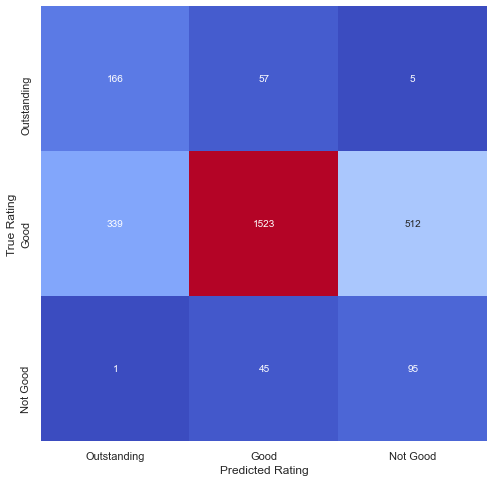

In [13]:
# run the logistic regression classifier across all the data to generate predicted results
logreg = multiclass.OneVsRestClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000))
logreg.fit(X, y)
y_pred = logreg.predict(X)


# generate a confusion matrix of the predicted results
ratings = ['Outstanding','Good','Not Good']
cm = metrics.confusion_matrix(y_pred, y, labels=ratings)

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', ax=ax, cbar=False)
ax.set_xticklabels(ratings)
ax.set_yticklabels(ratings)
ax.set_xlabel('Predicted Rating')
ax.set_ylabel('True Rating')

# generate classification metrics for the data
print(metrics.classification_report(y, y_pred, digits=3))

Running the logistic regression classifier over the whole shows a slightly improved accuracy score to the earlier calculated cross-validated score (65.0% v 62.7%) respectively.  A high amount of the confusion appears to be coming from the misclassification of good schools into the other two categories, which is perhaps understandable as the overwhelming number of schools assessed are classified as good.

### 5. Feature Engineering - Progress 8 Features

The Progress 8 features of the dataset have negative values indicating a less than average improvement for the average student within a school.  This causes issues as certain ML classifiers cannot accept negative values (such as Multinomial Naive Bayes).  A simple solve for this is to shift the axis so all values are positive.<br><br>
The axis is to be shifted for all the progress 8 variable by +5 to allow them all to still be comparable and convert all their values to positive.

In [14]:
df['P8MEA_shifted'] = df['P8MEA'] + 5
df['P8CILOW_shifted'] = df['P8CILOW'] + 5
df['P8CIUPP_shifted'] = df['P8CIUPP'] + 5

### 6. Feature Engineering - GENDER

Two potential methods for converting the nominal 'GENDER' variable into a usable ML format:
- Use one hot encoding to generate binomial columns for each of the 3 optional features<br><br>
- Combine the sparce 'boys' and 'girls' classes into one, before converting the variable into a binomial 'is_single_sex' variable

Option taken to combine the sparce classes and convert into one column as the occurrence of single sex schools is so remote compared to mixed sex establishments.

In [15]:
# create new varaible to identify if a school is single sex
df['is_same_sex'] = df['GENDER'].map({'Mixed':0, 'Girls':1, 'Boys':1})

### 7. Feature Engineering - RELCHAR

As the occurrences of religious affiliated schools are so sparce compared to the occurrences of schools with no religious affiliation we are justified to combine all the different religious schools into one 'is_RELCHAR' variable to simplify the data and render it usable for ML.  Also if all the different religions are included in the data this may add a lot of noise with additional features that do not contain large amounts of data as machine learning algorithms mostly work under the assumption that categorical data is uniformly distributed.

In [16]:
# create new varaible to identify if a school has a religeous affiliation
df['is_RELCHAR'] = np.where(df['RELCHAR'] == 'None', 0, 1)

# check value counts of the new varaible
df['is_RELCHAR'].value_counts()

0    2285
1     458
Name: is_RELCHAR, dtype: int64

### 8. Re-run of classifiers

In [17]:
# label the model run for the table
label = 'Feature Engineering 1st Pass'

# define new feature columns
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP'], axis=1)
y = df['Rating']

classifiers = [multiclass.OneVsRestClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)), 
               neighbors.KNeighborsClassifier(),
               MultinomialNB(), GaussianNB(), BernoulliNB()]

# run series of ML classifiers to assess accuracy
acc = [baseline]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    acc.append(round(scores.mean(), 3))
    
# append new accuracy scores to table for comparison
acc_scores[label] = acc
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass
0,Baseline,0.592,0.592
1,Logistic Regression,0.627,0.643
2,k-NN,0.191,0.191
3,MultinomialNB,0.417,0.420
4,GaussianNB,0.573,0.573
5,BernoulliNB,0.579,0.571


Largest positive change from the 1st pass of feature engineering is seen in the logistic regression classifier which has improved in accuracy by 1.6%.

### 9. Feature Engineering - Mixed Columns

For the mixed feature columns the decision was taken to replace the suppressed values with the average for the variable.  This decision was taken because often the values are suppressed as the number of pupils referred to is less than 5, such small populations can often provide outliers in data so by replacing with the average any outlier effects should be negated. <br><br>
The data interpolation was done as follows:
 - The 'PPERSABS10', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'OVERALL_DESTPER_DIS', and 'NOT_SUSTAINEDPER_DIS' variable column suppressed values were replaced with the median average value from the data (median was chosen as the more robust centrality measure due to the heavy skewing of the data in the variables) <br><br>
 - 'UNKNOWNPER' was re-calculated as the remainder from the 'OVERALL_DESTPER' and 'NOT_SUSTAINEDPER' variables to ensure the populations added up to 100% <br><br>
 - 'UNKNOWNPER_DIS' was re-calculated as the remainder from the 'OVERALL_DESTPER_DIS' and 'NOT_SUSTAINEDPER_DIS' variables to ensure the populations added up to 100% <br><br>
 - 'P8_BANDING' was shown to be related to a schools 'P8MEA' score in previous analysis (component 2 - section 7).  To replace suppressed values the mean 'P8MEA' score for each 'P8_BANDING' is calculated for available data, and the suppressed values then replaced by the banding of the closest banding mean 'P8MEA' to their own score <br><br>
 - All columns are given the suffix 'NO_SUPP' to show that they have been modified

In [18]:
# create new badning varaible with no suppressed values
df['P8_BANDING_NO_SUPP'] = df['P8_BANDING']

# create banding boundaries
B1 = (df.groupby('P8_BANDING')['P8MEA'].mean()[0] + df.groupby('P8_BANDING')['P8MEA'].mean()[1]) / 2
B2 = (df.groupby('P8_BANDING')['P8MEA'].mean()[1] + df.groupby('P8_BANDING')['P8MEA'].mean()[2]) / 2
B3 = (df.groupby('P8_BANDING')['P8MEA'].mean()[2] + df.groupby('P8_BANDING')['P8MEA'].mean()[3]) / 2
B4 = (df.groupby('P8_BANDING')['P8MEA'].mean()[3] + df.groupby('P8_BANDING')['P8MEA'].mean()[4]) / 2

# set conditions to define banding
c1 = (df['P8MEA'] >= B1) & (df['P8_BANDING'] == 'SUPP')
c2 = (df['P8MEA'] >= B2) & (df['P8MEA'] < B1) & (df['P8_BANDING'] == 'SUPP')
c3 = (df['P8MEA'] >= B3) & (df['P8MEA'] < B2) & (df['P8_BANDING'] == 'SUPP')
c4 = (df['P8MEA'] >= B4) & (df['P8MEA'] < B3) & (df['P8_BANDING'] == 'SUPP')
c5 = (df['P8MEA'] < B4) & (df['P8_BANDING'] == 'SUPP')

# replace 'SUPP' values with calculated banding
df.loc[c1,'P8_BANDING_NO_SUPP'] = 1
df.loc[c2,'P8_BANDING_NO_SUPP'] = 2
df.loc[c3,'P8_BANDING_NO_SUPP'] = 3
df.loc[c4,'P8_BANDING_NO_SUPP'] = 4
df.loc[c5,'P8_BANDING_NO_SUPP'] = 5

# reset new varaible to integer values
df['P8_BANDING_NO_SUPP'] = df['P8_BANDING_NO_SUPP'].astype('int')

In [19]:
# replaced suppressed values with the median from the variable
df['PPERSABS10_NO_SUPP'] = df['PPERSABS10'].replace(['SUPP','NE','LOWCOV', 'SP'], 
                                                    df['PPERSABS10'].replace(['SUPP','NE','LOWCOV', 'SP'], np.nan).median())

df['OVERALL_DESTPER_NO_SUPP'] = df['OVERALL_DESTPER'].replace(['SUPP','NE','LOWCOV', 'SP'], 
                                                    df['OVERALL_DESTPER'].replace(['SUPP','NE','LOWCOV', 'SP'], np.nan).median())

df['NOT_SUSTAINEDPER_NO_SUPP'] = df['NOT_SUSTAINEDPER'].replace(['SUPP','NE','LOWCOV', 'SP'], 
                                                    df['NOT_SUSTAINEDPER'].replace(['SUPP','NE','LOWCOV', 'SP'], np.nan).median())

df['OVERALL_DESTPER_DIS_NO_SUPP'] = df['OVERALL_DESTPER_DIS'].replace(['SUPP','NE','LOWCOV', 'SP'], 
                                                    df['OVERALL_DESTPER_DIS'].replace(['SUPP','NE','LOWCOV', 'SP'], np.nan).median())

df['NOT_SUSTAINEDPER_DIS_NO_SUPP'] = df['NOT_SUSTAINEDPER_DIS'].replace(['SUPP','NE','LOWCOV', 'SP'], 
                                                    df['NOT_SUSTAINEDPER_DIS'].replace(['SUPP','NE','LOWCOV', 'SP'], np.nan).median())

# reset varaibles to float values
new_var = ['PPERSABS10_NO_SUPP', 'OVERALL_DESTPER_NO_SUPP', 'NOT_SUSTAINEDPER_NO_SUPP', 
   'OVERALL_DESTPER_DIS_NO_SUPP', 'NOT_SUSTAINEDPER_DIS_NO_SUPP']

df[new_var] = df[new_var].astype('float64')

In [20]:
# calculate remaining values for the 'UNKNOWNPER' and 'UNKNOWNPER_DIS' varaibles
df['UNKNOWNPER_NO_SUPP'] = 1 - (df['OVERALL_DESTPER_NO_SUPP'] + df['NOT_SUSTAINEDPER_NO_SUPP'])

df['UNKNOWNPER_DIS_NO_SUPP'] = 1 - (df['OVERALL_DESTPER_DIS_NO_SUPP'] + df['NOT_SUSTAINEDPER_DIS_NO_SUPP'])

# resetting any negative values in the columns to 0 for sanity purposes
df[['UNKNOWNPER_NO_SUPP','UNKNOWNPER_DIS_NO_SUPP']] = np.where(df[['UNKNOWNPER_NO_SUPP','UNKNOWNPER_DIS_NO_SUPP']] < 0,
                                                              0, df[['UNKNOWNPER_NO_SUPP','UNKNOWNPER_DIS_NO_SUPP']])

### 10. Re-run of classifiers

In [21]:
# label the model run for the table
label = 'Feature Engineering 2nd Pass'

# define new feature columns
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP'], axis=1)
y = df['Rating']

# run series of ML classifiers to assess accuracy
acc = [baseline]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    acc.append(round(scores.mean(), 3))
    
# append new accuracy scores to table for comparison
acc_scores[label] = acc
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass
0,Baseline,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647
2,k-NN,0.191,0.191,0.191
3,MultinomialNB,0.417,0.420,0.435
4,GaussianNB,0.573,0.573,0.595
5,BernoulliNB,0.579,0.571,0.579


The 2nd pass of feature engineering has seen the largest positive impact of the Naive Bayes classifiers, with the Multinomial and Gaussian methods increasing in accuracy by 1.5 and 2.2% respectively.

### 11. Normalising Features

In [22]:
# label the model run for the table
label = 'Normalised Features'

# define new feature columns
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP'], axis=1)
# import normalisation and apply to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
y = df['Rating']

# run series of ML classifiers to assess accuracy
acc = [baseline]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    acc.append(round(scores.mean(), 3))
    
# append new accuracy scores to table for comparison
acc_scores[label] = acc
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass,Normalised Features
0,Baseline,0.592,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647,0.665
2,k-NN,0.191,0.191,0.191,0.628
3,MultinomialNB,0.417,0.420,0.435,0.604
4,GaussianNB,0.573,0.573,0.595,0.581
5,BernoulliNB,0.579,0.571,0.579,0.600


Normalisation of the features has greatly improved the accuracy of the k-NN classifier, jumping from 19.1 to 62.8%, indicating that the differences in scaling of some of the features was having a large impact on its performance. <br><br>
We have also seen a large increase in the accuracy of the MultinomialNB classifier (by 16.9%) and more modest but significant increases in the accuracy of the logistic regression and BernouilliNB classifiers (1.8 and 2.1% respectively).<br><br>
Interestingly the performance of the GaussianNB classifier decreased with normalisation of the features.

### 12. Further Feature Engineering

Further future engineering techniques tried as follows:
1.	Converting heavily skewed data to a more uniform distribution
    -	This is done as we have a few features in the dataset which are heavily skewed and it will dampen the influence of outliers in the data
<br><br>
2.	Generating polynomial features in the data
    -	This is done to assess whether there are any feature interactions which are useful for the classifier as these would not be captured if using the features individually

In [23]:
# 1. Converting data to more uniform distributions

# select heavily skewed data to convert
columns = ['PSENELK', 'PFSM', 'PNUMFSMEVER', 'PTEBACC_94', 'PTEBACC_95', 'PPERSABS10_NO_SUPP']

# convert 'PTEBACC' varaible to 100% to avoid issues
df['PTEBACC_94'] = df['PTEBACC_94'] * 100
df['PTEBACC_95'] = df['PTEBACC_95'] * 100

# calculate sqrt of the columns to create a more even distribution
# sqrt selected over log to avoid zero value error issues
for col in columns:
    name = 'sqrt_' + col
    df[name] = np.sqrt(df[col])

In [24]:
# label the model run for the table
label = 'Uniform Features'

# define new feature columns
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP',
            'PSENELK', 'PFSM', 'PNUMFSMEVER', 'PTEBACC_94', 'PTEBACC_95', 'PPERSABS10_NO_SUPP'], axis=1)
X = min_max_scaler.fit_transform(X)
y = df['Rating']

# run series of ML classifiers to assess accuracy
acc = [baseline]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    acc.append(round(scores.mean(), 3))
    
# append new accuracy scores to table for comparison
acc_scores[label] = acc
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass,Normalised Features,Uniform Features
0,Baseline,0.592,0.592,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647,0.665,0.667
2,k-NN,0.191,0.191,0.191,0.628,0.629
3,MultinomialNB,0.417,0.420,0.435,0.604,0.606
4,GaussianNB,0.573,0.573,0.595,0.581,0.580
5,BernoulliNB,0.579,0.571,0.579,0.600,0.600


Modifying the features to be more uniform appears to have minimal impact on the accuracy of the classifiers.

In [25]:
# 2. Creating polynomial features
# 2nd order polynomial chosen as higher orders would take too long to process
poly = preprocessing.PolynomialFeatures(degree = 2, interaction_only = False)

# label the model run for the table
label = '2nd Order Poly Features'

# define new feature columns
X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP',
            'PSENELK', 'PFSM', 'PNUMFSMEVER', 'PTEBACC_94', 'PTEBACC_95', 'PPERSABS10_NO_SUPP'], axis=1)
X = poly.fit_transform(X)
X = min_max_scaler.fit_transform(X)
y = df['Rating']

# run series of ML classifiers to assess accuracy
acc = [baseline]

for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    acc.append(round(scores.mean(), 3))
    
# append new accuracy scores to table for comparison
acc_scores[label] = acc
acc_scores


,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass,Normalised Features,Uniform Features,2nd Order Poly Features
0,Baseline,0.592,0.592,0.592,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647,0.665,0.667,0.670
2,k-NN,0.191,0.191,0.191,0.628,0.629,0.639
3,MultinomialNB,0.417,0.420,0.435,0.604,0.606,0.555
4,GaussianNB,0.573,0.573,0.595,0.581,0.580,0.509
5,BernoulliNB,0.579,0.571,0.579,0.600,0.600,0.303


Creating polynomial features in the dataset has provided the largest positive change for the k-NN classifier, which has seen an increase in accuracy of 1%. <br><br>
The change has seen a large negative impact on all of the Naive Bayes classifiers, with the largest change seen in the Bernoulli method which has decreased in accuracy by 29.7%.

### 13. Feature Selection Methods

Feature selection is done to reduce noise from a dataset for machine learning purposes and is typically done using two main method types, filtering or wrapping. <br>

Filter methods involve selection of the most influential features based on a property of the features themselves (such as variance in the feature or correlation to a target variable).  To implement the method the features are ranked based on the property of choice and the top x features selected based on assessment from the user.  The advantage of filter methods is speed as they are typically very easy to implement and do not take much processing power to run, allowing them to be efficiently applied to high dimensional datasets.  The disadvantage is that they do not relate directly to the end product of the classifier (e.g. accuracy or root-mean-squared-error), meaning that there is a possibility that the characteristic being filtered for does not actually improve the error from the machine learning model. <br>

Wrapper methods on the other hand directly use the results of the machine learning model applied to reduce the number of chosen features from a dataset.  To implement the method a loop function is set up which runs the model with all the available features individually and chooses the one that reduces the error by the largest factor, before repeating this loop by cycling through all the remaining features in combination with the first and selecting the one which reduces the model error by the most.  This loop cycle is then repeated until the chosen number of features defined by the operator is selected.  The advantage of this technique is its intrinsic reduction in the error of the machine learning model which is absent from the filter method.  The disadvantage however is that the technique is inherently slow and requires a lot of processing power, meaning it is very time and resource costly to implement for high dimensional datasets.


### 14. Filter Method

3 potential filter method techniques for us to use on the dataset are as follows:

1. Filtering features based on variance
    - variance indicates the spread of the data in a feature, the higher the variance the more the data is spread out allowing a model a wider range of values to utilise when predicting the target class
    - for our dataset we can rank the features by their variance and select the number of features which shows the highest accuracy score <br><br>
2. Filtering based on correlation to the target class
    - correlation indicates the strength of a statistical relationship between two variables, the more a feature is correlated to the target the more useful it will be to predict that target class
    - for our data set we can use the F-test statistic (as the features are mostly continuous and the target is categorical) to rank the features for their correlation to the target class and select the number of features which shows the highest accuracy score<br><br>
3. Removing mutual information
    - some features in a dataset are directly calculated from others or can be predicted directly from them, when this is the case having both features adds no new information to the data and simply increases noise for the ML algorithm and they can be removed
    - for our dataset we can remove complementary data features (such as the 'PNORG' and 'PNORB' which always sum to 1)   
    
For our data we will use method 2, ranking the features based on their correlation to the target class.  Note that the 2nd order polynomial transform has been removed from the data to do this as leaving it in caused several error messages on the algorithm.


In [26]:
# label the model run for the table
label = 'Filter Method'

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df.drop(['LA', 'GENDER', 'RELCHAR', 'PPERSABS10', 'P8_BANDING', 'OVERALL_DESTPER', 'NOT_SUSTAINEDPER', 'UNKNOWNPER',
       'OVERALL_DESTPER_DIS', 'NOT_SUSTAINEDPER_DIS', 'UNKNOWNPER_DIS', 'Rating', 'P8MEA', 'P8CILOW', 'P8CIUPP',
            'PSENELK', 'PFSM', 'PNUMFSMEVER', 'PTEBACC_94', 'PTEBACC_95', 'PPERSABS10_NO_SUPP'], axis=1)
X = min_max_scaler.fit_transform(X)
y = df['Rating']

acc = [baseline]

for clf in classifiers:
    # run filter loop to look through all possible numbers of features to use
    clf_acc = []
    for x in range(1, 28):
        # define feature selection
        fs = SelectKBest(score_func=f_classif, k=x)
        # apply feature selection
        X_selected = fs.fit_transform(X, y)
        # calculate the cross validated accuracy
        scores = cross_val_score(clf, X_selected, y, cv=5, scoring = 'accuracy')
        clf_acc.append(round(scores.mean(),3))
        clf_acc_max = max(clf_acc)
    acc.append(clf_acc_max)

# update table
acc_scores[label] = acc
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass,Normalised Features,Uniform Features,2nd Order Poly Features,Filter Method
0,Baseline,0.592,0.592,0.592,0.592,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647,0.665,0.667,0.670,0.669
2,k-NN,0.191,0.191,0.191,0.628,0.629,0.639,0.639
3,MultinomialNB,0.417,0.420,0.435,0.604,0.606,0.555,0.607
4,GaussianNB,0.573,0.573,0.595,0.581,0.580,0.509,0.626
5,BernoulliNB,0.579,0.571,0.579,0.600,0.600,0.303,0.629


Application of the filter method has seen the largest gains for the GaussianNB and BernoulliNB classifiers, with increases in accuracy of 4.6 and 2.9% respectively. <br><br>
The k-NN classifier also showed a small increase in accuracy from this feature selection technique showing a gain in accuracy of 1% similar to that seen from generating 2nd order polynomial features in the dataset.

### 15. Wrapper Method

The k-NN means classifier was chosen for the wrapper method as this had shown the most improvement during the feature selection so far.  Again the polynomial feature transformation has been dropped as it produced error warnings with the method.

In [27]:
# label the model run for the table
label = 'Wrapper Method'

# wrapper method used to define the most influencial features from the dataset
# run in a loop to see the effects of adding more features into the classifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(neighbors.KNeighborsClassifier(), k_features=(1, 28), forward=True, floating=False, scoring = 'accuracy', cv = 5)
sfs.fit(X, y)

# ammend table with wrapper method results
acc = [np.nan] * 6
acc_scores[label] = acc
acc_scores.loc[acc_scores['Classifier'] == 'Baseline', 'Wrapper Method'] = baseline
acc_scores.loc[acc_scores['Classifier'] == 'k-NN', 'Wrapper Method'] = round(pd.DataFrame(sfs.get_metric_dict()).loc['avg_score', :].max(),3)
acc_scores

,Classifier,No Feature Engineering,Feature Engineering 1st Pass,Feature Engineering 2nd Pass,Normalised Features,Uniform Features,2nd Order Poly Features,Filter Method,Wrapper Method
0,Baseline,0.592,0.592,0.592,0.592,0.592,0.592,0.592,0.592
1,Logistic Regression,0.627,0.643,0.647,0.665,0.667,0.670,0.669,NaN
2,k-NN,0.191,0.191,0.191,0.628,0.629,0.639,0.639,0.658
3,MultinomialNB,0.417,0.420,0.435,0.604,0.606,0.555,0.607,NaN
4,GaussianNB,0.573,0.573,0.595,0.581,0.580,0.509,0.626,NaN
5,BernoulliNB,0.579,0.571,0.579,0.600,0.600,0.303,0.629,NaN


The wrapper feature selection method has provided an improvement of 2.9% in accuracy for the k-NN classifier.